# Linear regression with Laplace approximation

In [52]:
import jax
import numpy as np
import jax.numpy as jnp
import jax.scipy.stats as stats

from gaul import quap

import matplotlib.pyplot as plt
import seaborn as sns
import pears

plt.rcParams['figure.figsize'] = (11, 7)

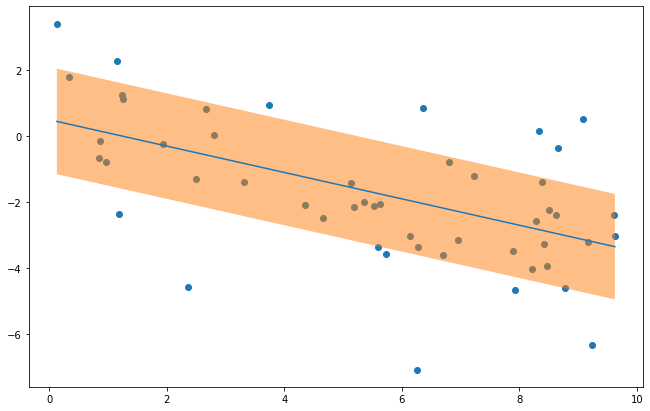

In [53]:
beta0 = 0.5
beta1 = -0.4
sigma = 1.6
n = 50

key = jax.random.PRNGKey(0)
xkey, ykey = jax.random.split(key)

x = jax.random.uniform(xkey, shape=(n,)) * 10.
x = jnp.sort(x)
ymean = beta0 + beta1 * x
y = jax.random.normal(ykey, shape=(n,)) * sigma + ymean

plt.scatter(x, y)
plt.plot(x, ymean)
plt.fill_between(x, ymean - sigma, ymean + sigma, alpha=0.5)

In [54]:
def ln_posterior(params, data):
    target = 0
    
    target += stats.norm.logpdf(params['beta0'], 0., 2.)
    target += stats.norm.logpdf(params['beta1'], 0., 2.)
    target += stats.expon.logpdf(jnp.exp(params['sigma']), scale=1.)

    ymean = params['beta0'] + params['beta1'] * data['x']
    target += stats.norm.logpdf(data['y'], ymean, jnp.exp(params['sigma'])).sum()

    return target.sum()

In [55]:
params = dict(
    beta0=jnp.zeros(1),
    beta1=jnp.zeros(1),
    sigma=jnp.ones(1),
)

data = dict(
    x=x,
    y=y,
)

In [56]:
samples = quap.sample(
    ln_posterior,
    params,
    n_steps=1000,
    n_samples=1000,
    data=data
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [57]:
samples = jax.tree_util.tree_map(lambda x: x.reshape(-1), samples)

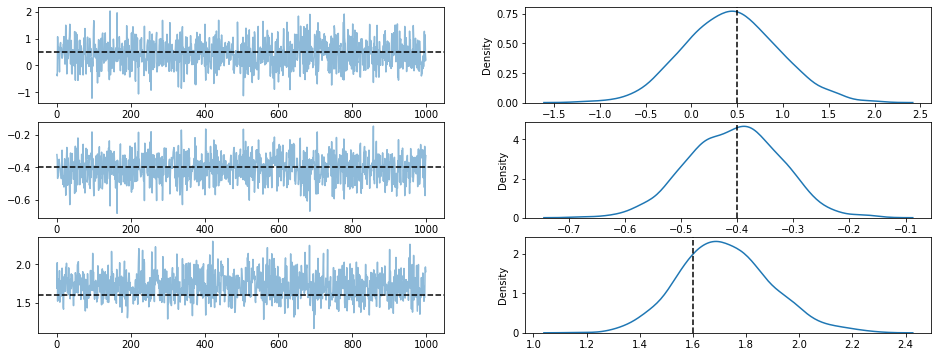

In [58]:
fig, ax = plt.subplots(3, 2, figsize=(16, 6))

plot_data = [samples['beta0'], samples['beta1'], jnp.exp(samples['sigma'])]
truths = [beta0, beta1, sigma]

for i in range(3):
    ax[i,0].plot(plot_data[i], alpha=0.5)
    ax[i,0].axhline(truths[i], c='k', ls='--')
    sns.kdeplot(plot_data[i], ax=ax[i,1])
    ax[i,1].axvline(truths[i], c='k', ls='--')

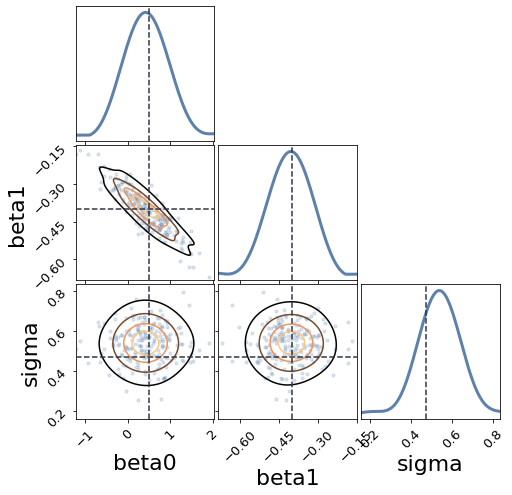

In [59]:
pears.pears(samples, truths=[beta0, beta1, jnp.log(sigma)], scatter_thin=5, hspace=0.03, wspace=0.03);

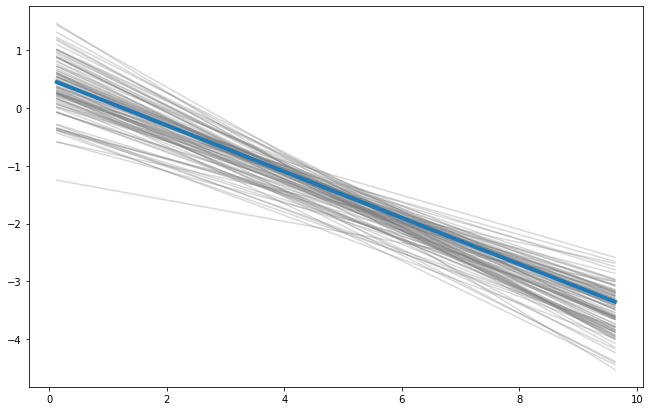

In [62]:
def sim_linreg(beta0, beta1, sigma):
    ymean_sim = beta0 + beta1 * x
    return ymean_sim

y_sim = jax.vmap(sim_linreg)(
    samples['beta0'],
    samples['beta1'],
    samples['sigma'],
)

for i in range(100):
    plt.plot(x, y_sim[i], c='grey', alpha=0.3)
plt.plot(x, ymean, lw=4)